In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
trainset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 1,  9,  5,  3])


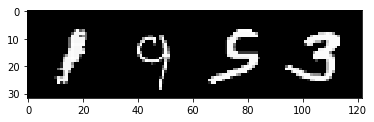

Process Process-1:
Process Process-2:
Traceback (most recent call last):
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/hsue/anaconda3/envs/Pytorch/

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

def imshow(img):
    npimg = img.numpy()
    #print(npimg.shape)
    im = np.transpose(npimg, (1,2,0))
    #print(im.shape)
    plt.imshow(im) #np.transpose(npimg, (1,2,0)))

imshow(torchvision.utils.make_grid(images))
print(labels)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.Conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.Conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.MaxPool = nn.MaxPool2d(2)
        self.Fc = nn.Linear(320,10)
        
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.MaxPool(self.Conv1(x)))
        x = F.relu(self.MaxPool(self.Conv2(x)))
        x = x.view(in_size, -1)
        x = self.Fc(x)
        return F.log_softmax(x)
        
net = Net()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print("Let's use ",torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)

net.to(device)

Let's use  2 GPUs!


DataParallel(
  (module): Net(
    (Conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (Conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Fc): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
def train(epoch):
    net.train()
    for batch_idx,(imgs,labels) in enumerate(trainloader):
        imgs,labels = Variable(imgs),Variable(labels)
        imgs,labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(imgs), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))
            
    print("Training finished")

In [7]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs,labels = imgs.to(device), labels.to(device)

            outputs = net(imgs)
            test_loss += criterion(outputs,labels).data[0]
            pred = outputs.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).cpu().sum()

        test_loss /= len(testloader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(testloader.dataset), 100. * correct / len(testloader.dataset)))

In [8]:
for epoch in range(1,2):
    train(epoch)
    test()

torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.290480
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])

/home/hsue/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/hsue/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()



torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])torch.Size([2, 500])

torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch

torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])torch.Size([2, 500])

torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 10, 13, 13])

torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])torch.Size([2, 500])

torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500

torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])torch.Size([2, 20, 5, 5])
torch.Size([2, 500])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 10, 13, 13])

torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5

torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 10, 13, 13])torch.Size([2, 500])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])torch.Size([2, 20, 5, 5])
torch.Size([2, 500]

torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 20,

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 500])
torch.

torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])torch.Size([2, 20, 5, 5])
torch.Size([2, 500])

torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500

torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 

torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 10, 13, 13])

torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500

torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])torch.Size([2, 500])

torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])torch.Size([2, 20, 5, 5])
torch.Size([2, 500]

torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 10, 13, 13])

torch.Size([2, 500

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.013745
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 10, 13, 13])torch.Size([2, 500])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])



torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 10, 13, 13])torch.Size([2, 500])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 10, 13, 13])torch.Size([2, 500])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 10, 13, 13])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 10, 13, 13])

torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13]

torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])torch.Size([2, 500])

torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 

torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 10, 13, 13])torch.Size([2, 500])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 20,

torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 10, 13, 13])

torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13

torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 10, 13, 13])torch.Size([2, 500])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])torch.Size([2, 10, 13, 13]

torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])torch.Size([2, 500])

torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])torch.Size([2, 20, 5, 5])

torch.Size([2, 500

torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])torch.Size([2, 500])

torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])torch.Size([2, 500])

torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 20,

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.

torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])torch.Size([2, 20, 5, 5])

torch.Size([2, 500])
torch.Size([2, 500])
torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5])
torch.Size([2, 20, 5, 5])
torch.Size([2, 500])torch.Size([2, 500])

torch.Size([2, 10, 13, 13])torch.Size([2, 10, 13, 13])

torch.Size([2, 20, 5, 5

Process Process-4:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/hsue/anaconda3/envs/Pytorch/l

Traceback (most recent call last):
  File "/home/hsue/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-274bece848f2>", line 2, in <module>
    train(epoch)
  File "<ipython-input-6-d80549dd75ef>", line 8, in train
    outputs = net(imgs)
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/site-packages/torch/nn/modules/module.py", line 491, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py", line 114, in forward
    outputs = self.parallel_apply(replicas, inputs, kwargs)
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py", line 124, in parallel_apply
    return parallel_apply(replicas, inputs, kwargs, self.device_ids[:len(replicas)])
  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/site-packa

KeyboardInterrupt: 

  File "/home/hsue/anaconda3/envs/Pytorch/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
